## Constructing a riskless yield curve for USD
The first thing we need to do to price any option on a US equity is construct the so-called riskless yield curve for USD. This is because pricing of derivatives is done in _the risk-neutral world_ where all investors are assumed not to require a premium for additional risks, hence future cashflows are discounted using the riskless rate to obtain the NPV of the cashflow.

I use the Fed Funds effective rate and US Treasury Yields as proxies for riskless rates. Ideally, using OIS swap rates might be better as treasury yields tend to be slightly lower given the preferred tax treatment of treasuries. However US Treasury Rates are available for free from [FRED](https://fred.stlouisfed.org) with daily frequency while OIS swap rates not, and the difference is pretty small.

I use the following dataseries from FRED to accomplish the task:
* DFF &mdash; Federal Funds Effective Rate (daily frequency)
* DGS1MO &mdash; Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS3MO &mdash; Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS6MO &mdash; Market Yield on U.S. Treasury Securities at 6-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS1 &mdash; Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS2 &mdash; Market Yield on U.S. Treasury Securities at 2-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS3 &mdash; Market Yield on U.S. Treasury Securities at 3-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS5 &mdash; Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS7 &mdash; Market Yield on U.S. Treasury Securities at 7-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS10 &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS20 &mdash; Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS30 &mdash; Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)

In the `pricing.curves.YieldCurve` class I use cubic splines by default to interpolate when constructing the curve. See [this article](http://web.math.ku.dk/~rolf/HaganWest.pdf) for more details on interpolation methods if you want to know more. Cubic splines is pretty advanced.

In [1]:
import locale
from datetime import date, datetime

from dateutil.relativedelta import relativedelta
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
import numpy as np
import pandas as pd

from volatility import parameter_estimators
from volatility import volatility_trackers
from pricing import curves
from pricing import options

_ = locale.setlocale(locale.LC_ALL, '')

In [2]:
today = date.today()

# Offsetting to the last business day if today is not a business day
today = today if len(pd.bdate_range(today, today)) else today - BDay(1)

# Constructing the riskless yield curve based on the current fed funds rate and treasury yields
data = web.get_data_fred(
    ['DFF', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'],
    today - BDay(2), today)
data.dropna(inplace=True)

cur_date_curve = data.index[-1].date()

# Convert to percentage points
data /= 100.

# Some adjustments are required to bring FED Funds rate to the same day count convention and compounding frequency
# as treasury yields (actual/actual with semi-annual compounding):
# 1. https://www.federalreserve.gov/releases/h15/default.htm -> day count convention for Fed Funds Rate needs
# to be changed to actual/actual
# 2. Conversion to APY: https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/interest-rates-frequently-asked-questions
data.DFF *= (366 if curves.YieldCurve.is_leap_year(cur_date_curve.year) else 365) / 360 # to x/actual
data.DFF = 2 * (np.sqrt(data.DFF + 1) - 1)

offsets = [relativedelta(), relativedelta(months=+1), relativedelta(months=+3), relativedelta(months=+6),
           relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+3), relativedelta(years=+5),
           relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+20),
           relativedelta(years=+30)]

# Define the riskless yield curve
curve = curves.YieldCurve(today, offsets, data[cur_date_curve:cur_date_curve + BDay()].to_numpy()[0, :],
                          compounding_freq=2)

### Optional: Visualizing the riskless yield curve for USD

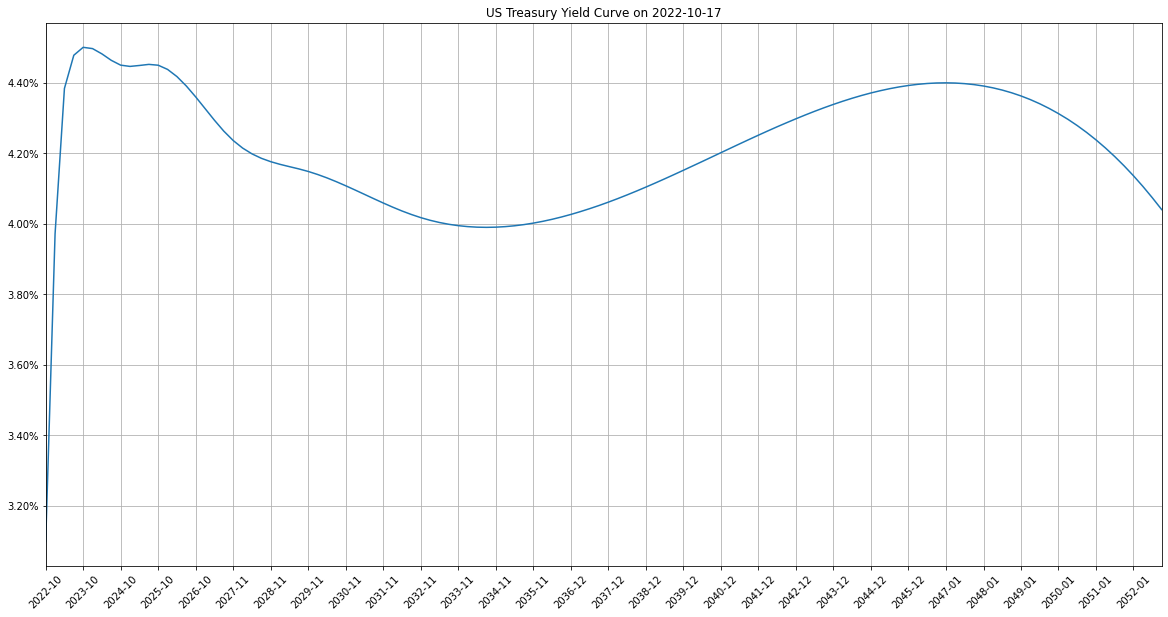

In [3]:
import matplotlib.ticker as mtick
curve_points = curve.get_curve_points(120)
ax = curve_points.plot(figsize=(20,10), grid=True, title='US Treasury Yield Curve on ' + cur_date_curve.strftime('%Y-%m-%d'),
                       xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), curve_points.index[::4])))